In [71]:
import yaml
import os
from pathlib import Path
import pandas as pd
import struct
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sys

# also: cd hammer && pip install -e . 

# Setup

In [23]:
# experiment setup
PDK = 'sky130'
CLOCK_PERIOD = 10 if PDK == 'sky130' else 2 # ns

# useful paths
energy_char_dpath = Path(os.getcwd()).parent
tests_dpath = energy_char_dpath/f'experiments/tests-{PDK}'
tests_dpath

PosixPath('/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130')

# Generate experiment files

In [70]:
# get pdk clock periods, paths
PDKs = ["sky130"]
clock_periods, test_paths = {}, {}
for pdk in PDKs:
    clock_periods[pdk] = (10 if pdk == "sky130" else 2)
    test_paths[pdk] = energy_char_dpath/f'experiments/tests-{pdk}'

operations = ['add', 'mul']
op_to_inst = {'add':'adder0', 'mul':'multiplier0'}
num_inputs = 50
widths = [4, 8, 16, 32, 64]
activity_factors = [0.1, 0.5, 0.9]

width_to_max = {}
for i in widths:
    width_to_max[i] = (1 << i) - 1
# tests dict
#   name format: <design>-<test_name>
#       inputs: list, where each item is a tuple of items per line in input.txt
#       defines: for verilog

## Activity Factor Based Input Generation

In [40]:
## get binary string
def getBinary(num, width):
	binary_str = ""
	for i in range(width):
		if (num & (1 << i)):
			binary_str += '1'
		else:
			binary_str += '0'
	return binary_str[::-1]

## find (a, b) s.t. a + b = num
def findNums(num, operation, tryall):
	a, b = 0, 0
	if (operation == 'add'):
		a = random.randint(0, num)
		b = num - a
	elif (operation == 'mul'):
		a, b = 1, num
		if (tryall): ## get all factors of num and choose a pair at random
			allpairs = []
			for i in range(1, int(num ** 0.5) + 1):
				if (num % i == 0):
					allpairs.append((i, num // i))
			a, b = allpairs[random.randint(0, len(allpairs) - 1)]
	return (a, b)


## flip the output (cur_num) given the width and activity factor (prob)
def flip(cur_num, width, prob):
	ret = 0
	for i in range(width):
		on = ((cur_num & (1 << i)) > 0)
		rand_num = random.random()
		## flip bit
		if (rand_num <= prob):
			ret += ((not on) * (1 << i))
		else:
			ret += (on * (1 << i))
	return ret

## verify that the integer pairs (nums) generated from a specified width and activity factor are sensible
def output(width, factor, nums):
	print(f'Width: {width}, Activity Factor: {factor}')
	prev = ""
	for (a, b) in nums:
		print((a, b))
		binary_str = getBinary(a + b, width)
		print(f'New Binary String: {binary_str}')
		if (prev):
			pc = sum([0 if binary_str[i] == prev[i] else 1 for i in range(width)]) / width
			print(f'Percent change: {pc}')
		prev = binary_str


def getInputs(width, activity_factor, num_iter, operation, tryall):
	nums = [(0, 0)]
	for i in range(num_iter - 1):
		new_num = flip(sum(nums[-1]), width, activity_factor)
		nums.append(findNums(new_num, operation, tryall))
	#output(width, activity_factor, nums) #<-- USE THIS TO VERIFY THAT INPUT PAIRS ARE LOGICAL
	return nums

In [44]:
def getMaxInputSwitching(num, operation):
    return (num, num)

def getMaxOutputSwitching(num, operation):
    if (operation == 'add'):
        a = int(num/2)
        b = num - a
        return (a, b)
    elif (operation == 'mul'):
        return (1, num)


## Generate All Testbenchs

In [45]:
tests_dict = {}
for operation in operations:
    cur_tests = {}
    for width in widths:
        design = f"{operation}{width}"
        max_num = width_to_max[width]

        original_tests = {
            f'{design}-zero': {
                'inputs': [(0,0) for i in range(num_inputs)],
                'defines': dict(WIDTH=width),
            },
            f'{design}-max_input_switching': {
                # input operands alternate between 0 and all 1's
                'inputs': [((0, 0) if i % 2 else getMaxInputSwitching(max_num, operation)) for i in range(num_inputs)],
                'defines': dict(WIDTH=width),
            },
            f'{design}-max_output_switching': {
                # output operands alternate between 0 and all 1's (so set inputs accordingly)
                'inputs': [((0, 0) if i % 2 else getMaxOutputSwitching(max_num, operation)) for i in range(num_inputs)],
                'defines': dict(WIDTH=width),
            }
        }
        
        activity_factor_tests = {}
        for factor in activity_factors:
            activity_factor_tests[f'{design}-activity-factor={factor}'] = {
                'inputs': getInputs(width, factor, num_inputs, operation, 0),
                'defines': dict(WIDTH=width),
            }
            
        cur_tests.update(original_tests)
        cur_tests.update(activity_factor_tests)

    ## per width, we add len(activity_factors) tests and then another three from Nayiri's original tests
    ## assert(len(add_tests) == ((len(activity_factors) * len(widths)) + (len(widths) * 3)))

    for t in cur_tests:
        cur_tests[t]['design'] = t.split('-')[0]
        cur_tests[t]['inst'] = f'/{operation}/{op_to_inst[operation]}'
        cur_tests[t]['clock'] = 'clock'
        cur_tests[t]['vsrcs'] = [f'src/{operation}.v']
        cur_tests[t]['vsrcs_tb'] = [f'src/{operation}_tb.v']
        cur_tests[t]['top_module'] = f'{operation}'
        cur_tests[t]['tb_name'] = f'{operation}_tb'
        cur_tests[t]['tb_dut'] = f'{operation}_dut'
        cur_tests[t]['input_ports'] = ['in0','in1']
        cur_tests[t]['output_ports'] = ['out']
    
    tests_dict.update(cur_tests)

print(tests_dict)

{'add8-zero': {'inputs': [(0, 0), (0, 0), (0, 0), (0, 0)], 'defines': {'WIDTH': 8}, 'design': 'add8', 'inst': '/add/adder0', 'clock': 'clock', 'vsrcs': ['src/add.v'], 'vsrcs_tb': ['src/add_tb.v'], 'top_module': 'add', 'tb_name': 'add_tb', 'tb_dut': 'add_dut', 'input_ports': ['in0', 'in1'], 'output_ports': ['out']}, 'add8-max_input_switching': {'inputs': [(255, 255), (0, 0), (255, 255), (0, 0)], 'defines': {'WIDTH': 8}, 'design': 'add8', 'inst': '/add/adder0', 'clock': 'clock', 'vsrcs': ['src/add.v'], 'vsrcs_tb': ['src/add_tb.v'], 'top_module': 'add', 'tb_name': 'add_tb', 'tb_dut': 'add_dut', 'input_ports': ['in0', 'in1'], 'output_ports': ['out']}, 'add8-max_output_switching': {'inputs': [(127, 128), (0, 0), (127, 128), (0, 0)], 'defines': {'WIDTH': 8}, 'design': 'add8', 'inst': '/add/adder0', 'clock': 'clock', 'vsrcs': ['src/add.v'], 'vsrcs_tb': ['src/add_tb.v'], 'top_module': 'add', 'tb_name': 'add_tb', 'tb_dut': 'add_dut', 'input_ports': ['in0', 'in1'], 'output_ports': ['out']}, 'add

### Input files

In [46]:
# create dirs
for test_name, test_info in tests_dict.items():
    # experiment directory - will contain all input/output files
    root = tests_dpath/test_name
    root.mkdir(exist_ok=True,parents=True)
    test_info['defines']['TESTROOT'] = root
    test_info['root'] = root
    # hammer build directory
    test_info['obj_dpath'] = energy_char_dpath/f"build-{PDK}-cm/{test_info['design']}"

# convert data operands to binary format to dump to input.txt (gets more complicated for floats)
def val2binary(val,input_format='') -> str:
    if type(val) == str: return val
    elif type(val) == int: return '{0:b}'.format(val)
    elif type(val) == float:
        pack_format = '!e'
        if input_format == 'float32':       pack_format = '!f'
        elif input_format == 'float64':     pack_format = '!d'
        return ''.join('{:0>8b}'.format(c) for c in struct.pack(pack_format, val))
    else: assert(False), f"Invalid dtype, {type(val)}"


# write out input.txt
for test_name, test_info in tests_dict.items():
    input_format = test_info['input_format'] if 'input_format' in test_info else '' # only used for floating point
    with (test_info['root']/'input.txt').open('w') as f:
        for operands in test_info['inputs']:
            f.write(" ".join([val2binary(operand,input_format) for operand in operands]) + '\n')


### Hammer Config

In [47]:
def write_cfg(td):
  defines_str = '\n'.join( [ f"  - {key}={val}" for key,val in td['defines'].items() ] )
  clock_period = 10 if PDK == 'sky130' else 2
  delays = [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: input}}""" for i in td['input_ports']]
  delays += [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: output}}""" for i in td['output_ports']]
  delays = ',\n  '.join(delays)
  cfg = f"""\
vlsi.core.build_system: make
vlsi.inputs.power_spec_type: cpf
vlsi.inputs.power_spec_mode: auto

design.defines: &DEFINES
  - CLOCK_PERIOD={clock_period}
{defines_str}

vlsi.inputs.clocks: [{{name: "clock", period: "{clock_period}ns", uncertainty: "100ps"}}]

vlsi.inputs.delays: [
  {delays}
]

synthesis.inputs:
  top_module: {td['top_module']}
  input_files: {td['vsrcs']}
  defines: *DEFINES

sim.inputs:
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  options: ["-timescale=1ns/10ps", "-sverilog"]
  options_meta: append
  defines: *DEFINES
  defines_meta: append
  level: rtl
  input_files: {td['vsrcs'] + td['vsrcs_tb']}

vlsi.core.power_tool: hammer.power.joules
power.inputs:
  level: rtl
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  defines: *DEFINES
  input_files: {td['vsrcs']}
  report_configs:
    - waveform_path: {td['root']}/output.fsdb
      report_stem: {td['root']}/power
      toggle_signal: {td['clock']}
      num_toggles: 1
      levels: all
      output_formats:
      - report
      - plot_profile
"""
  with (td['root']/'config.yml').open('w') as f:
    f.write(cfg)

for t in tests_dict:
  write_cfg(tests_dict[t])

## Run experiments

In [48]:
# Setup
overwrite = False
verbose = False

def runCmd(cmd,verbose=verbose):
    print(f'Executing commmand: {cmd}')
    subprocess.run(f'cd {energy_char_dpath} && {cmd}', 
                                shell=True, check=True, capture_output=(not verbose))

# generate custom make str for each test
make_extra = f"pdk={PDK}"
if PDK == 'intech22': make_extra += f" PDK_CONF=experiments/intech22.yml"
for t,td in tests_dict.items():
    cfg = str(td['root']/'config.yml')
    td['make'] = f"design={td['design']} {make_extra} DESIGN_CONF={cfg}"

# subprocess.run starts in an empty environment, need to ensure it can find hammer-vlsi
python_exec_fpath = Path(sys.executable)
env_dpath = str(python_exec_fpath.parent)
if not os.environ['PATH'].startswith(env_dpath): os.environ['PATH'] = env_dpath + ':' + os.environ['PATH']

# build
build_dpaths = {td['obj_dpath']: t for t,td in tests_dict.items()} # run build once per build dir (not once per test)
for bd,t in build_dpaths.items():
    if overwrite or not bd.exists():
        result = runCmd(f"make build {tests_dict[t]['make']} -B")

# syn
for bd,t in build_dpaths.items():
    if overwrite or not (bd/"syn-rundir/reports").exists():
        runCmd(f"make syn {tests_dict[t]['make']}")

# sim-rtl
for t in tests_dict:
    fp = tests_dict[t]['root']/'output.fsdb'
    if overwrite or not fp.exists():
        runCmd(f"make redo-sim-rtl {tests_dict[t]['make']}")


# power-rtl: synthesize design in power tool + save checkpoint
for bd,t in build_dpaths.items():
    if overwrite or not (tests_dict[t]['obj_dpath']/'power-rtl-rundir/pre_report_power').exists():
        runCmd(f"make power-rtl {tests_dict[t]['make']}")

# redo-power-rtl: run subsequent experiments by loading post-synth power checkpoint
for t in tests_dict:
    if overwrite or not (tests_dict[t]['root']/'power.power.rpt').exists():
        # re-use pre_report_power database if it's already generated (i.e. skip synthesis)
        make_target = "redo-power-rtl args='--only_step report_power'"
        runCmd(f"make {make_target} {tests_dict[t]['make']}")



Executing commmand: make build design=add8 pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add8-activity-factor=0.5/config.yml -B
Executing commmand: make build design=add16 pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add16-activity-factor=0.5/config.yml -B
Executing commmand: make build design=mul8 pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/mul8-activity-factor=0.5/config.yml -B
Executing commmand: make build design=mul16 pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/mul16-activity-factor=0.5/config.yml -B
Executing commmand: make syn design=add8 pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add8-activity-factor=0.5/config.yml
Executing c

## Parse results

In [51]:
def parse_hier_power_rpt(fpath,inst) -> list:
    with fpath.open('r') as f: lines = f.readlines()
    for l in lines:
        words = l.split()
        if l.startswith('Power Unit'):
            assert(words[-1] == 'mW'), f"Wrong power unit in report, {l}"
        if inst == words[-1]:
            return [float(p) for p in words[2:6]]
    return []

def get_duration(fpath) -> float:
    with fpath.open('r') as f: lines = f.readlines()
    time_power = [l.split() for l in lines]
    time_power = [tp for tp in time_power if len(tp) == 2]
    start = float(time_power[0][0])
    end   = float(time_power[-1][0])
    return end-start

time = []
output_af = []
power = list([])

for t in tests_dict:
    fpath = tests_dict[t]['root']/'power.hier.power.rpt'
    cur_power = parse_hier_power_rpt(fpath,tests_dict[t]['inst'])
    power.append(cur_power)
    fpath = tests_dict[t]['root']/'power.profile.png.data'
    cur_op, design_name, cur_factor = "", "", 0

    '''
    for operation in operations:
        for w in widths:
            if f"{operation}{w}" in str(tests_dict[t]['root']):
                design_name = f"{operation}{w}"
                cur_op = operation
    '''
#    print(design_name)

    cur_factor = float("nan")
    for factor in activity_factors:
        if f"activity-factor={factor}" in str(tests_dict[t]['root']):
            cur_factor = factor
    if "max_output_switching" in str(tests_dict[t]['root']):
        cur_factor = 1
    if "zero" in str(tests_dict[t]['root']):
        cur_factor = 0
    
    cur_time = get_duration(fpath)
    time.append(cur_time)
    output_af.append(cur_factor)

power = pd.DataFrame(power,   #  mW
                     columns=['Leakage','Internal','Switching','Total'],
                     index=tests_dict.keys()) # type: ignore



energy = power.mul(time,axis=0) / num_inputs # mW * ns = pJ
energy.columns = [c+' Energy (pJ)' for c in energy.columns]
energy.insert(0,'output_af',output_af)
energy.insert(0,'time',time)
energy.insert(0,'test',[i.split('-')[1] for i in energy.index])
energy.insert(0,'design',[i.split('-')[0] for i in energy.index])

#print(results_for_plots)
energy.to_hdf(PDK+'.h5',key='df',mode='w')
energy


,design,test,time,output_af,Leakage Energy (pJ),Internal Energy (pJ),Switching Energy (pJ),Total Energy (pJ)
add8-zero,add8,zero,45.0,0.0,0.000002,0.000000,0.000000,0.000002
add8-max_input_switching,add8,max_input_switching,45.0,NaN,0.000002,0.579172,10.465976,11.045149
add8-max_output_switching,add8,max_output_switching,45.0,1.0,0.000002,0.495873,11.824425,12.320325
add8-activity-factor=0.5,add8,activity,45.0,0.5,0.000002,0.235453,3.759480,3.994942
add16-zero,add16,zero,45.0,0.0,0.000003,0.000000,0.000000,0.000003
add16-max_input_switching,add16,max_input_switching,45.0,NaN,0.000004,1.285222,22.595288,23.880488
add16-max_output_switching,add16,max_output_switching,45.0,1.0,0.000003,1.065504,23.725800,24.791400
add16-activity-factor=0.5,add16,activity,45.0,0.5,0.000004,0.472923,7.567335,8.040263
mul8-zero,mul8,zero,45.0,0.0,0.000002,0.000000,0.000000,0.000002
mul8-max_input_switching,mul8,max_input_switching,45.0,NaN,0.000003,0.707335,2.173849,2.881181


## Generate Plot

''

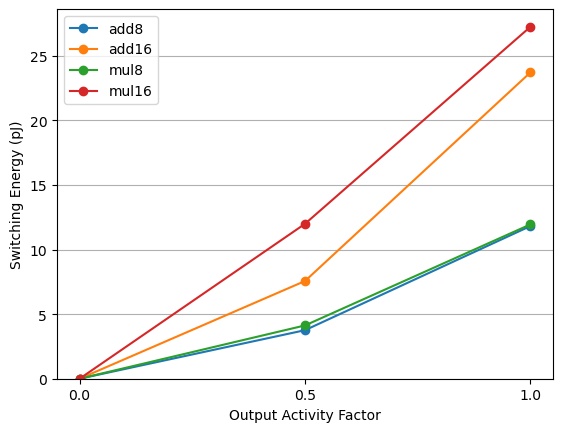

In [52]:
ykey = 'Switching Energy (pJ)'
# ykey = 'Internal (pJ)'

designs =  list(dict.fromkeys(energy['design']).keys())
for design in designs:
    df = energy[~energy['output_af'].isna() & (energy['design'] == design)].sort_values('output_af')
    hd = df['output_af']
    e = df[ykey]
    plt.plot(hd,e,'o-',label=design)
    plt.xticks(hd)


plt.legend()
plt.xlabel('Output Activity Factor')
plt.ylabel(ykey)
plt.grid(axis='y')
plt.ylim(bottom=0)
;

[8, 16] [np.float64(3.7594799999999995), np.float64(7.567335)]
[8, 16] [np.float64(4.12698375), np.float64(11.997562499999999)]


Text(0, 0.5, 'Switching Energy (pJ)')

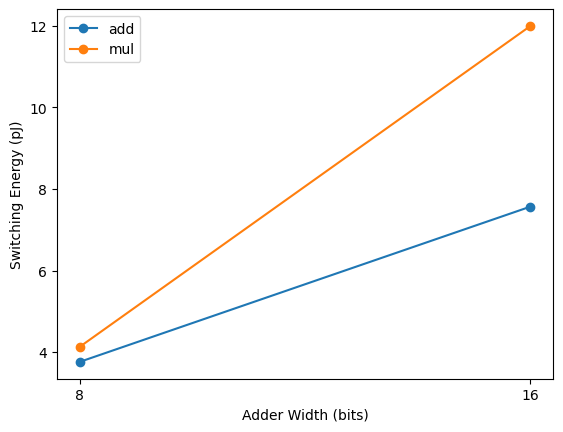

In [69]:
ykey = "Switching Energy (pJ)"

data = energy[energy['output_af'] == 0.5]
for operation in operations:
    widths, skip = [], []
    ind = 0
    for val in data['design']:
        if operation in val:
            widths.append(int(val.replace(operation,'')))
        else:
            skip.append(ind)
        ind += 1
    energies = data[ykey].values
    valid_energies = []
    for i in range(len(energies)):
        if i not in skip:
            valid_energies.append(energies[i])
    print(widths, valid_energies)
    plt.plot(widths,valid_energies,'o-', label=operation)
    plt.xticks(widths)
plt.legend()
plt.xlabel("Adder Width (bits)")
plt.ylabel(ykey)


## Notes
What do we want to test?

Inputs:
* 0 -> 0
* 0 -> 11...11
* different activity factors of adds

Designs:
* minimum critical path - can we force the synthesis tool to use faster gates

Flow:
* sim-rtl > power-rtl